In [5]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn
import IPython.display as ipd
import random
import ast
import keras
import tensorflow as tf

from pandas.api.types import CategoricalDtype
from collections import Counter
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from pandas.api.types import CategoricalDtype
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from scipy.stats.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 150

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

<AxesSubplot:>

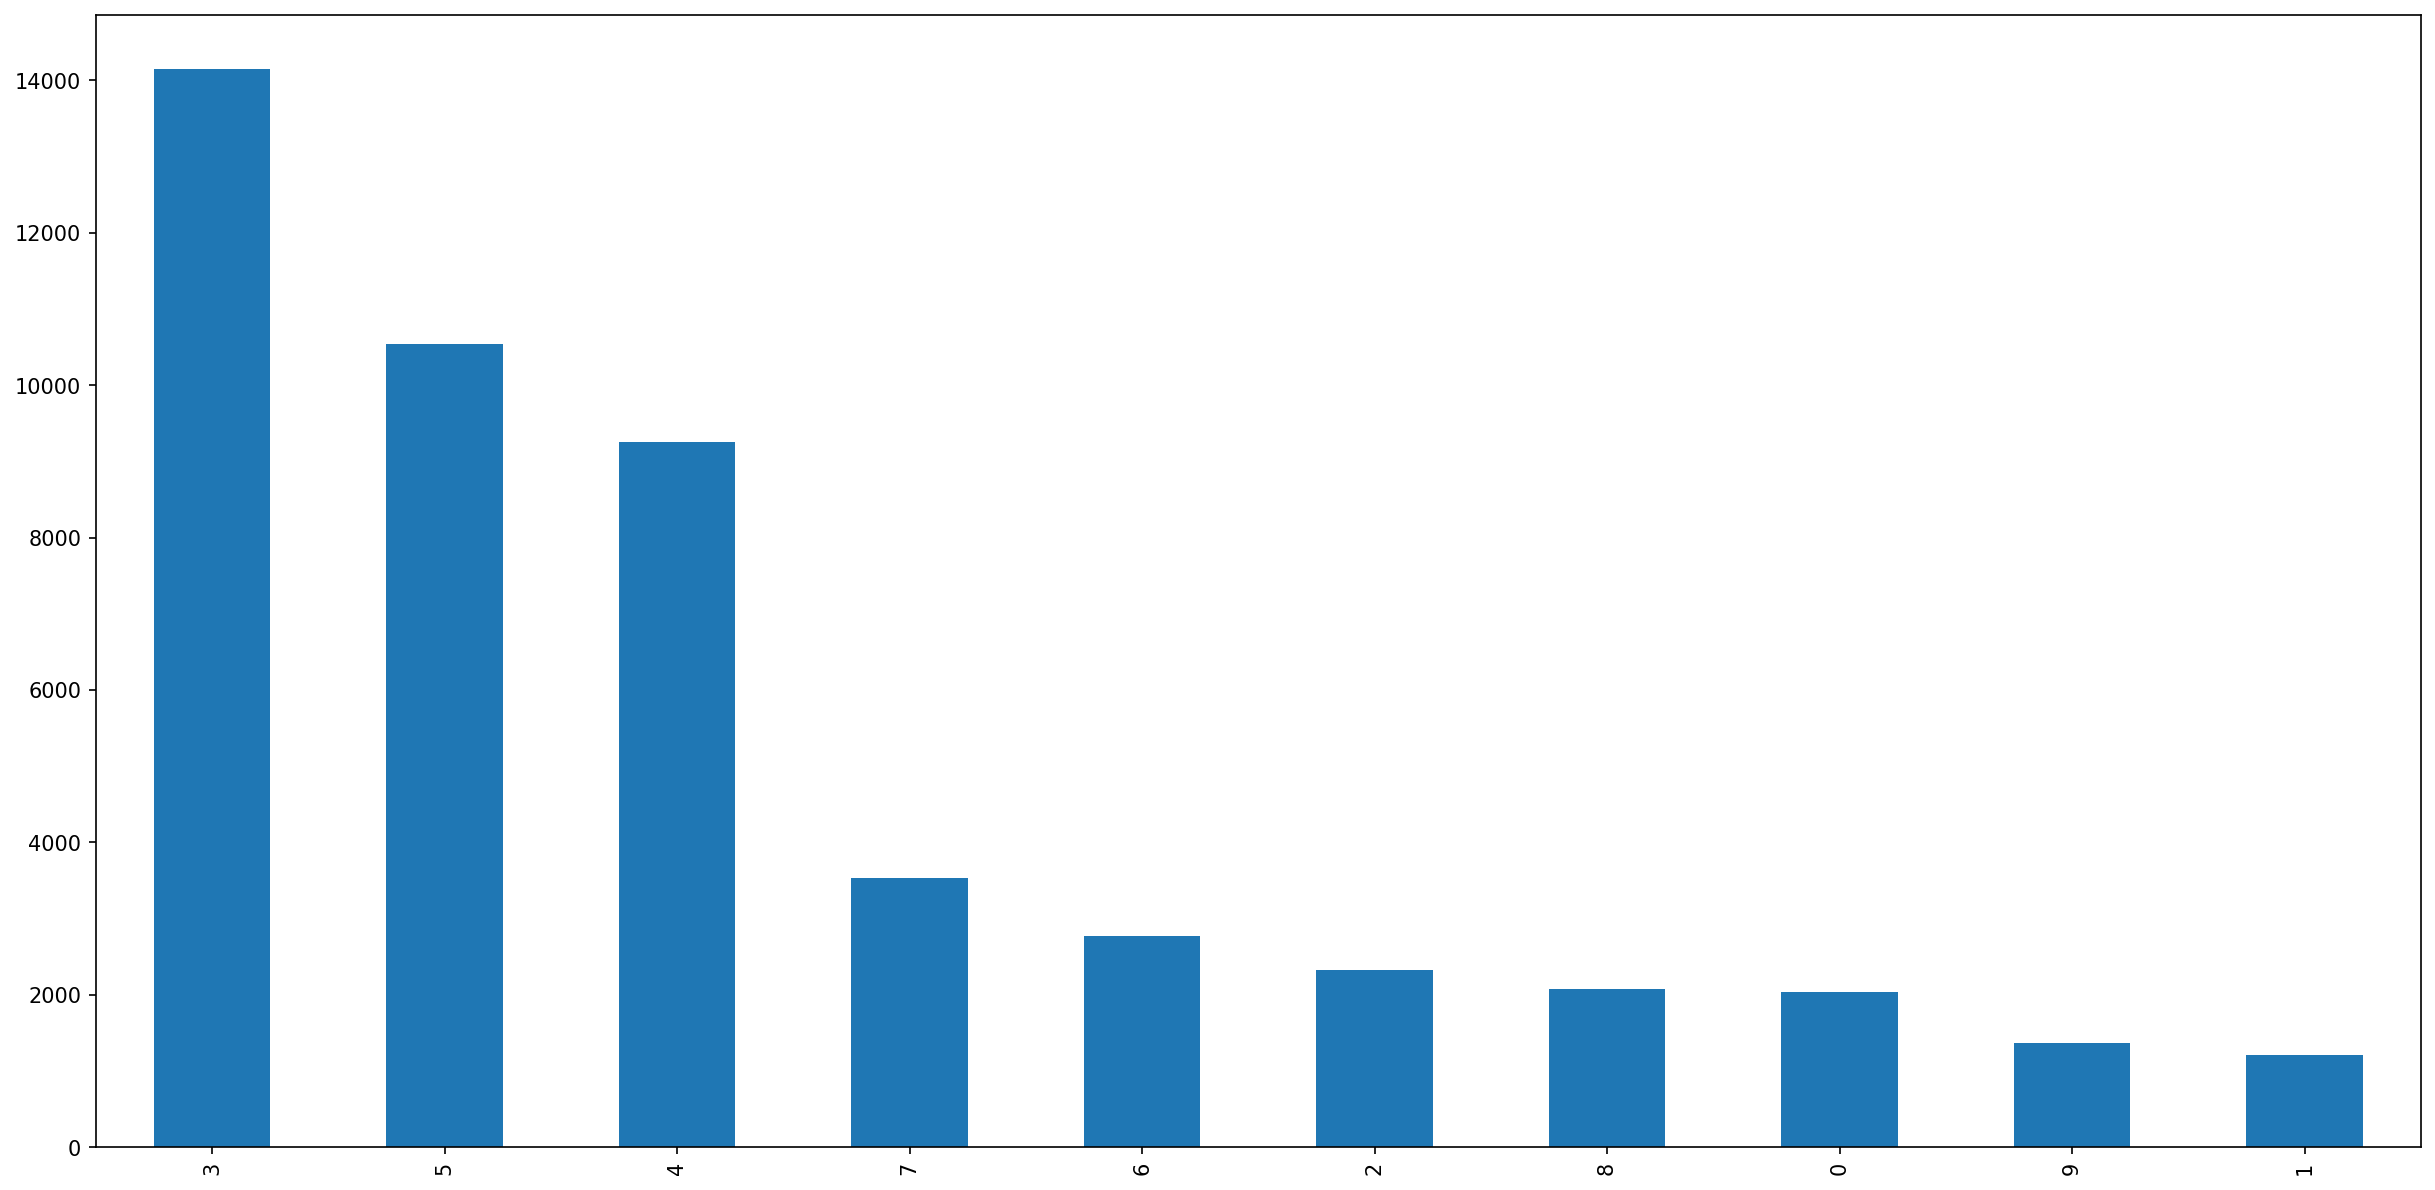

In [6]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli

label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df['TRACK_genre_top_num'] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df['TRACK_genre_top_num']]



df['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df['TRACK_genre_top_num']]


df['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df['TRACK_genre_top_num']] #rock 13 --> 3
df['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df['TRACK_genre_top_num']] #pop 12 --> 2

df.TRACK_genre_top_num.value_counts().plot(kind='bar')

In [7]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

# [OPZ] codice per creare le bitmap

In [ ]:
bitmaps = {}
bitmaps[0] = pd.get_dummies(df["ALBUM_date_released_year_"].apply(pd.Series).stack()).sum(level=0)

bitmaps[1] = pd.get_dummies(df["ALBUM_tracks_"].apply(pd.Series).stack()).sum(level=0)

bitmaps[2] = pd.get_dummies(df["ALBUM_type_"].apply(pd.Series).stack()).sum(level=0)
bitmaps[3] = pd.get_dummies(df["TRACK_bitrate"].apply(pd.Series).stack()).sum(level=0)


for i in range(4):
    df = pd.concat([df, bitmaps[i]], axis=1)

    
df.drop(columns=["ALBUM_date_released_year_", 'ALBUM_tracks_', 'ALBUM_type_', 'TRACK_bitrate'], inplace=True)

df

In [ ]:
#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl

# [OPZ] codice per reinserire tutte le features

### ATTENZIONE: non rimuove le features ottenute con la PCA

In [ ]:
featuresdf = pd.read_csv('fma_metadata_progetto/features.csv', index_col=0, header=[0, 1, 2])

flat_features = pd.DataFrame()

for l1 in featuresdf.columns:
    name = ""
    for l2 in l1:
        name = name + l2
        
    flat_features[name] = featuresdf[l1]
    
df = pd.merge(df, flat_features, left_index=True, right_index=True)

df

In [ ]:
#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])


compl

# Sklearn Multilayer Perceptron

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [8]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, [class_name]) #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

#Scalo i dati (ris no PCA, 1000, 500)
scaler = StandardScaler()    #0.6931610633836163
#scaler = MinMaxScaler()     #0.6896435094365149    ma ci mette una marea a convergere
#scaler = RobustScaler()     #0.6920110938239871

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
clf = MLPClassifier(random_state=0, hidden_layer_sizes=(1000, 500), learning_rate='adaptive', max_iter=1000, 
                    verbose=True, early_stopping=True)


#top 600, 300 6964080362578637         6895758641683014 (con tutte le bitmap)
#top 1000, 500 700872623959954         6974227152810661 <---
#top 2000, 1000 7085841845362917       7031725630792126
#top 4000, 2000 7109517689237638       6951227761618075

#----------3
# top 600 600 300 6950551308935939
# top 900 600 300 7058783738077522
# top 1200 800 400  7058783738077522

#---------4 
# top 1200 800 400 100 6990462017181898 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Iteration 1, loss = 1.20739275
Validation score: 0.664058
Iteration 2, loss = 0.99515856
Validation score: 0.668696
Iteration 3, loss = 0.91591845
Validation score: 0.682609
Iteration 4, loss = 0.84818798
Validation score: 0.688116
Iteration 5, loss = 0.78849348
Validation score: 0.679710
Iteration 6, loss = 0.73712344
Validation score: 0.702319
Iteration 7, loss = 0.68092748
Validation score: 0.699130
Iteration 8, loss = 0.63283353
Validation score: 0.704638
Iteration 9, loss = 0.57832433
Validation score: 0.705797
Iteration 10, loss = 0.53455138
Validation score: 0.698841
Iteration 11, loss = 0.47859892
Validation score: 0.708696
Iteration 12, loss = 0.43026993
Validation score: 0.703768
Iteration 13, loss = 0.38374542
Validation score: 0.711014
Iteration 14, loss = 0.34518499
Validation score: 0.715362
Iteration 15, loss = 0.28857675
Validation score: 0.710725
Iteration 16, loss = 0.26529384
Validation score: 0.706957
Iteration 17, loss = 0.22721412
Validation score: 0.710725
Iterat

# Keras Deep Neural Networks

In [10]:
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, [class_name]) #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

#--------------Oversampling:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler(random_state=42)
#X_res, y_res = ros.fit_resample(X_train, y_train)


#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)

X_res = X_train
y_res = y_train

#-------------Undersampling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

#rus = RandomUnderSampler(random_state=42)
#X_val, y_val = rus.fit_resample(X_val, y_val)



scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

scaler.fit(X_res)
X_res = scaler.transform(X_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



unique, counts = np.unique(y_train, return_counts=True)
print("train", dict(zip(unique, counts)))

unique, counts = np.unique(y_res, return_counts=True)
print("bilanciato", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("validation", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("test", dict(zip(unique, counts)))


#Trasformo la target value in vettore con 1 sulla posizione del genere giusto
y_res = tf.keras.utils.to_categorical(y_res, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

train {0: 1293, 1: 751, 2: 1458, 3: 8979, 4: 5847, 5: 6632, 6: 1708, 7: 2226, 8: 1295, 9: 853}
bilanciato {0: 1293, 1: 751, 2: 1458, 3: 8979, 4: 5847, 5: 6632, 6: 1708, 7: 2226, 8: 1295, 9: 853}
validation {0: 132, 1: 97, 2: 170, 3: 929, 4: 634, 5: 749, 6: 233, 7: 249, 8: 154, 9: 103}
test {0: 611, 1: 364, 2: 697, 3: 4247, 4: 2778, 5: 3163, 6: 832, 7: 1061, 8: 621, 9: 409}


In [12]:
# FUNZIONI PER COSTRUIRE LA NN
def costruisci(n_layer_crescenti=5, initialHiddenLayer=128, n_layer_decrescenti = 5, finalHiddenLayer=128):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    
    for n in range(1, n_layer_crescenti+1):
        model.add(Dense(initialHiddenLayer*(n), activation='relu'))
        print("creo layer crescente di dimensione ", initialHiddenLayer*(n))
    for n in range(n_layer_decrescenti , 0, -1): #CODICE DEI TEST: for n in range(n_layer_decrescenti, 0, -1):
        model.add(Dense(finalHiddenLayer*(n), activation='relu'))
        print("creo layer decrescente di dimensione ", finalHiddenLayer*(n))
        
    model.add(Dense(y_res.shape[1], activation=tf.nn.softmax))

    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #<-- binario
    model.compile(loss='categorical_crossentropy', 
                  metrics=['accuracy'],
                  #optimizer='adam',
                  optimizer='adamax'
                  #optimizer='nadam'
                  #optimizer='adadelta'

                 ) #<-- multilabel/multiclass
    
    return model

In [19]:
model = costruisci(n_layer_crescenti=1, 
                   initialHiddenLayer=800,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=400)

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)


history1 = model.fit(X_res, y_res, epochs=1000, 
                      #batch_size= 200,
                      #class_weight=class_weight,
                      validation_data=(X_val, y_val), callbacks=[es,mc]
                     ).history

creo layer crescente di dimensione  800
creo layer decrescente di dimensione  400
Epoch 1/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.4005 - accuracy: 0.5466 - val_loss: 1.1937 - val_accuracy: 0.6058
Epoch 2/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.0889 - accuracy: 0.6382 - val_loss: 1.1149 - val_accuracy: 0.6217
Epoch 3/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.0157 - accuracy: 0.6654 - val_loss: 1.0954 - val_accuracy: 0.6310
Epoch 4/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.9374 - accuracy: 0.6899 - val_loss: 1.0470 - val_accuracy: 0.6484
Epoch 5/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.9043 - accuracy: 0.6964 - val_loss: 1.0357 - val_accuracy: 0.6559
Epoch 6/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.8442 - accuracy: 0.7181 - val_loss: 1.0315 - val_accuracy: 0.6438
Epoch 7/1000
971/971 [==============================] 

In [25]:
layer1 = range(600, 1600, 200)
layer2 = range(300, 1300 +1, 200)

result = {}

for a in tqdm(layer1):
    for b in tqdm(layer2):
        model = costruisci(n_layer_crescenti=1, 
                   initialHiddenLayer=a,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=b)
        
        es = EarlyStopping(monitor='val_loss', patience=30)
        mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)


        history1 = model.fit(X_res, y_res, epochs=1000, 
                              #batch_size= 200,
                              #class_weight=class_weight,
                              validation_data=(X_val, y_val), callbacks=[es,mc]
                             ).history
        
        test_loss, test_acc = model.evaluate(X_val, y_val)
        
        result[str(a)+"-"+str(b)] = str(test_acc) + str( test_loss)
        
        print('%f-%f     VAL: Loss %f, Accuracy %f' % (a, b, test_loss, test_acc))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

creo layer crescente di dimensione  800
creo layer decrescente di dimensione  800
Epoch 1/1000
971/971 [==============================] - 15s 14ms/step - loss: 1.3749 - accuracy: 0.5493 - val_loss: 1.1783 - val_accuracy: 0.6055
Epoch 2/1000
971/971 [==============================] - 12s 12ms/step - loss: 1.0782 - accuracy: 0.6423 - val_loss: 1.0969 - val_accuracy: 0.6359
Epoch 3/1000
971/971 [==============================] - 12s 12ms/step - loss: 0.9810 - accuracy: 0.6756 - val_loss: 1.0774 - val_accuracy: 0.6461
Epoch 4/1000
971/971 [==============================] - 11s 11ms/step - loss: 0.9215 - accuracy: 0.6891 - val_loss: 1.0438 - val_accuracy: 0.6551
Epoch 5/1000
971/971 [==============================] - 8s 8ms/step - loss: 0.8787 - accuracy: 0.7066 - val_loss: 1.0296 - val_accuracy: 0.6548
Epoch 6/1000
971/971 [==============================] - 6s 6ms/step - loss: 0.8142 - accuracy: 0.7273 - val_loss: 1.0164 - val_accuracy: 0.6678
Epoch 7/1000
971/971 [========================

971/971 [==============================] - 6s 6ms/step - loss: 0.0091 - accuracy: 0.9996 - val_loss: 2.0491 - val_accuracy: 0.6788
Epoch 34/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.0077 - accuracy: 0.9998 - val_loss: 2.1005 - val_accuracy: 0.6765
Epoch 35/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.0065 - accuracy: 0.9998 - val_loss: 2.1291 - val_accuracy: 0.6780
Epoch 36/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.0052 - accuracy: 0.9997 - val_loss: 2.1686 - val_accuracy: 0.6788
Epoch 37/1000
108/108 [==============================] - 0s 2ms/step - loss: 2.2880 - accuracy: 0.6814
800.000000-1400.000000     VAL: Loss 2.288001, Accuracy 0.681449
creo layer crescente di dimensione  800
creo layer decrescente di dimensione  1700
Epoch 1/1000
971/971 [==============================] - 4s 4ms/step - loss: 1.3966 - accuracy: 0.5415 - val_loss: 1.1737 - val_accuracy: 0.6093
Epoch 2/1000
971/971 [=================

  0%|          | 0/4 [00:00<?, ?it/s]

creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  800
Epoch 1/1000
971/971 [==============================] - 4s 4ms/step - loss: 1.3761 - accuracy: 0.5476 - val_loss: 1.1676 - val_accuracy: 0.6119
Epoch 2/1000
971/971 [==============================] - 3s 4ms/step - loss: 1.0690 - accuracy: 0.6450 - val_loss: 1.1125 - val_accuracy: 0.6307
Epoch 3/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.9806 - accuracy: 0.6742 - val_loss: 1.0644 - val_accuracy: 0.6443
Epoch 4/1000
971/971 [==============================] - 4s 4ms/step - loss: 0.9107 - accuracy: 0.6959 - val_loss: 1.0514 - val_accuracy: 0.6417
Epoch 5/1000
971/971 [==============================] - 5s 5ms/step - loss: 0.8388 - accuracy: 0.7142 - val_loss: 1.0186 - val_accuracy: 0.6672
Epoch 6/1000
971/971 [==============================] - 5s 5ms/step - loss: 0.7739 - accuracy: 0.7386 - val_loss: 0.9892 - val_accuracy: 0.6699
Epoch 7/1000
971/971 [==============================]

Epoch 36/1000
108/108 [==============================] - 0s 3ms/step - loss: 2.3049 - accuracy: 0.6835
1100.000000-1400.000000     VAL: Loss 2.304901, Accuracy 0.683478
creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  1700
Epoch 1/1000
971/971 [==============================] - 6s 6ms/step - loss: 1.3738 - accuracy: 0.5533 - val_loss: 1.1523 - val_accuracy: 0.6197
Epoch 2/1000
971/971 [==============================] - 6s 6ms/step - loss: 1.0588 - accuracy: 0.6471 - val_loss: 1.1167 - val_accuracy: 0.6342
Epoch 3/1000
971/971 [==============================] - 5s 6ms/step - loss: 0.9772 - accuracy: 0.6741 - val_loss: 1.0543 - val_accuracy: 0.6452
Epoch 4/1000
971/971 [==============================] - 6s 6ms/step - loss: 0.8839 - accuracy: 0.7037 - val_loss: 1.0281 - val_accuracy: 0.6516
Epoch 5/1000
971/971 [==============================] - 6s 6ms/step - loss: 0.8067 - accuracy: 0.7268 - val_loss: 0.9974 - val_accuracy: 0.6554
Epoch 6/1000
971/971 [=====

  0%|          | 0/4 [00:00<?, ?it/s]

creo layer crescente di dimensione  1400
creo layer decrescente di dimensione  800
Epoch 1/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.3801 - accuracy: 0.5512 - val_loss: 1.1805 - val_accuracy: 0.6064
Epoch 2/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.0699 - accuracy: 0.6485 - val_loss: 1.1021 - val_accuracy: 0.6296
Epoch 3/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.9727 - accuracy: 0.6786 - val_loss: 1.0590 - val_accuracy: 0.6472
Epoch 4/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.8992 - accuracy: 0.7023 - val_loss: 1.0225 - val_accuracy: 0.6623
Epoch 5/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.8313 - accuracy: 0.7216 - val_loss: 0.9926 - val_accuracy: 0.6664
Epoch 6/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.7729 - accuracy: 0.7402 - val_loss: 0.9814 - val_accuracy: 0.6667
Epoch 7/1000
971/971 [==============================]

Epoch 35/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 2.3002 - val_accuracy: 0.6872
Epoch 36/1000
108/108 [==============================] - 0s 1ms/step - loss: 2.3805 - accuracy: 0.6875
1400.000000-1400.000000     VAL: Loss 2.380479, Accuracy 0.687536
creo layer crescente di dimensione  1400
creo layer decrescente di dimensione  1700
Epoch 1/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.3648 - accuracy: 0.5527 - val_loss: 1.1669 - val_accuracy: 0.6136
Epoch 2/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.0542 - accuracy: 0.6523 - val_loss: 1.1125 - val_accuracy: 0.6316
Epoch 3/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.9503 - accuracy: 0.6844 - val_loss: 1.0599 - val_accuracy: 0.6452
Epoch 4/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.8821 - accuracy: 0.7005 - val_loss: 1.0247 - val_accuracy: 0.6614
Epoch 5/1000
971/971 [====

  0%|          | 0/4 [00:00<?, ?it/s]

creo layer crescente di dimensione  1700
creo layer decrescente di dimensione  800
Epoch 1/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.3674 - accuracy: 0.5496 - val_loss: 1.1588 - val_accuracy: 0.6214
Epoch 2/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.0749 - accuracy: 0.6410 - val_loss: 1.0874 - val_accuracy: 0.6304
Epoch 3/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.9627 - accuracy: 0.6800 - val_loss: 1.0399 - val_accuracy: 0.6513
Epoch 4/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.8943 - accuracy: 0.6999 - val_loss: 1.0043 - val_accuracy: 0.6649
Epoch 5/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.8201 - accuracy: 0.7222 - val_loss: 1.0117 - val_accuracy: 0.6658
Epoch 6/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.7611 - accuracy: 0.7452 - val_loss: 0.9997 - val_accuracy: 0.6745
Epoch 7/1000
971/971 [==============================]

Epoch 35/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 2.5808 - val_accuracy: 0.6809
Epoch 36/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 2.5506 - val_accuracy: 0.6907
Epoch 37/1000
108/108 [==============================] - 0s 1ms/step - loss: 2.5067 - accuracy: 0.6849
1700.000000-1400.000000     VAL: Loss 2.506659, Accuracy 0.684928
creo layer crescente di dimensione  1700
creo layer decrescente di dimensione  1700
Epoch 1/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.3720 - accuracy: 0.5506 - val_loss: 1.1566 - val_accuracy: 0.6214
Epoch 2/1000
971/971 [==============================] - 2s 2ms/step - loss: 1.0485 - accuracy: 0.6547 - val_loss: 1.0868 - val_accuracy: 0.6391
Epoch 3/1000
971/971 [==============================] - 2s 2ms/step - loss: 0.9420 - accuracy: 0.6869 - val_loss: 1.0518 - val_accuracy: 0.6519
Epoch 4/1000
971/971 [===

In [26]:
dict(sorted(result.items(), key=lambda item: item[1]))

{'800-800': '0.6762318611145022.2404749393463135',
 '800-1100': '0.6762318611145022.3196237087249756',
 '1100-1700': '0.6782608628273012.337672472000122',
 '1400-800': '0.67855072021484382.25087571144104',
 '1100-800': '0.67942029237747192.2469706535339355',
 '800-1700': '0.67942029237747192.365679979324341',
 '1700-1700': '0.67971014976501462.5250625610351562',
 '1400-1700': '0.68086957931518552.60028338432312',
 '800-1400': '0.6814492940902712.2880008220672607',
 '1100-1100': '0.68202900886535642.4322619438171387',
 '1400-1100': '0.68260872364044192.356480121612549',
 '1700-800': '0.68289852142333982.3978283405303955',
 '1100-1400': '0.68347823619842532.304901361465454',
 '1700-1400': '0.68492752313613892.5066585540771484',
 '1400-1400': '0.68753623962402342.380479335784912',
 '1700-1100': '0.69275361299514772.324765920639038'}

'800-1200': '0.6924637556076052.134887456893921',
 '1200-1400': '0.6924637556076052.2831122875213623',
 '1300-1100': '0.69333332777023322.321800947189331',
 '1200-1700': '0.6944927573204042.3965771198272705',
 '1200-1300': '0.69855070114135742.325577735900879',
 '1100-1500': '0.6999999880790712.2375428676605225'}

In [14]:
test_loss, test_acc = model.evaluate(X_val, y_val)

print('VAL: Loss %f, Accuracy %f' % (test_loss, test_acc))

test_loss, test_acc = model.evaluate(X_test, y_test)

print('TEST: Loss %f, Accuracy %f' % (test_loss, test_acc))

108/108 [==============================] - 0s 1ms/step - loss: 1.1610 - accuracy: 0.6846
VAL: Loss 1.161048, Accuracy 0.684638
462/462 [==============================] - 0s 1ms/step - loss: 1.1402 - accuracy: 0.6746
TEST: Loss 1.140161, Accuracy 0.674559


In [ ]:
# Per runnare il modello finchè non è trovato un modello migliore
accuracyDaSuperare = 0.0

while True:
    model = costruisciTop(n_layer_crescenti=4, 
                   initialHiddenLayer=80,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=300)


    history1 = model.fit(X_res, y_res, epochs=1000, 
                          #batch_size= 128,
                          #class_weight=class_weight,
                          validation_data=(X_val, y_val), callbacks=[es,mc]
                         ).history
    
    test_loss, test_acc = model.evaluate(X_val, y_val)
    
    if(test_acc > accuracyDaSuperare):
        break
    
    clear_output(wait=True)
    print("")

In [ ]:
model.save("modello_top")

In [ ]:
y_pred = model.predict(X_test)

y_pred_bool = np.argmax(y_pred, axis=1) #si deve usare argmax o predict_classes
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

In [ ]:
#classi predette e istanze per classe

y_pred = model1.predict_classes(X_test)

unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
#Funzione per svuotare la VRAM nel caso non vengo fatto in automatico
K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()